# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

Загрузим и посмотрим на данные

In [2]:
ds = pd.read_csv('/datasets/autos.csv')
display(ds.head())
ds.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Разрабатываемое приложение предназначено для опредедения рыночной стоимости своего автомобиля потенциальными клиентами. Отберем данные для дальнейшей обработки исключив избыточные столбцы которые явно не могут влиять на определение стоимости автомобиля нового клиента. Это DateCrawled (дата скачивания анкеты из базы), DateCreated (дата создания анкеты), NumberOfPictures (количество фотографий автомобиля), PostalCode (почтовый индекс владельца анкеты), LastSeen (дата последней активности пользователя). Также отбросим столбец RegistrationMonth (месяц регистрации автомобиля), оставим RegistrationYear - год регистрации важнее.

In [3]:
pr_ds = ds[['VehicleType', 
            'Gearbox', 
            'Power',
            'Kilometer',
            'FuelType',
            'Brand',
            'NotRepaired',
            'RegistrationYear',
            'Model',
            'Price']]
pr_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
VehicleType         316879 non-null object
Gearbox             334536 non-null object
Power               354369 non-null int64
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
RegistrationYear    354369 non-null int64
Model               334664 non-null object
Price               354369 non-null int64
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Проверим на пропуски

In [5]:
print(pr_ds.isna().sum())
print()
print('Всего пропусков:', pr_ds.isna().sum().sum())

VehicleType         37490
Gearbox             19833
Power                   0
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
RegistrationYear        0
Model               19705
Price                   0
dtype: int64

Всего пропусков: 181077


В отобранных данных 354369 записей в 10 столбцах. Данные имеют целочисленный тип (int64) и тип object - строковые. Признаки VehicleType (тип автомобильного кузова), Gearbox (тип коробки передач), Model (модель автомобиля), FuelType (тип топлива), NotRepaired (была машина в ремонте или нет) содержат пропуски.  

Рассмотим детальнее целевой признак Price

In [6]:
pr_ds.Price.describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

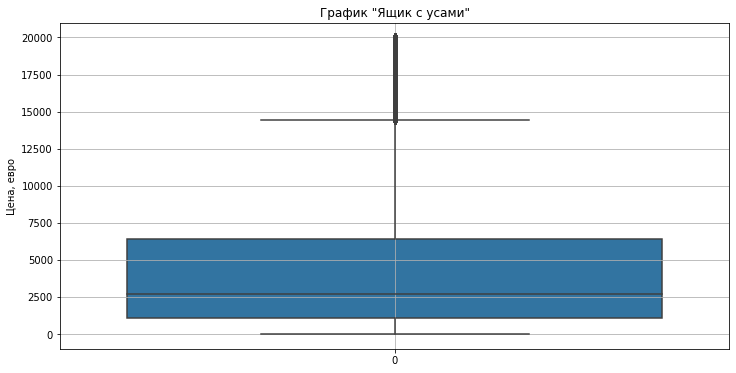

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=pr_ds.Price)
plt.grid()
plt.title('График "Ящик с усами"')
plt.ylabel('Цена, евро')
plt.show()

В целевом признаке Price, наблюдаются аномальные значения 0, стоимость продажи автомобмиля не может быть нулевой. Медианная цена чуть выше 2500 евро, верхний квартиль проходит на уровне 6400 евро, 75% значений выборки не выходят за этот порог. При этом максимальная цена достигает 20000, разброс ощутимый. Посмтрим распределение цен в нижнем ценовом дапазоне

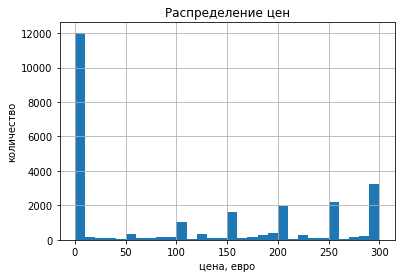

In [8]:
ax = pr_ds['Price'].hist(bins=30, range = (0, 300))
ax.set_title('Распределение цен')
ax.set_xlabel('цена, евро')
ax.set_ylabel('количество')
plt.show()

Выброс в районе 0, цены до 100 евро встречаются не часто, такая стоимость автомобиля тоже вызывает вопросы. Установим нижний порог в 100 евро. Отсечем выбросы в верхнем ценовом дапазоне, установим верхний порог на уровне 75% перцентили плюс 1,5 х Межквартильный размах = 14850

In [9]:
pr_ds = pr_ds.query('100 <= Price <= 14850')
pr_ds.Price.describe()

count    323993.000000
mean       3927.705747
std        3547.816613
min         100.000000
25%        1190.000000
50%        2689.000000
75%        5800.000000
max       14850.000000
Name: Price, dtype: float64

Посмотрим на данные в столбце RegistrationYear

In [10]:
pr_ds.RegistrationYear.describe()

count    323993.000000
mean       2003.646952
std          68.198188
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Год регистрации явно содержит аномальные значения, т.к. min 1000, max 9999. Первый автомобиль появился в 1886 году, максимальный год регистарции не может быть больше максимальной даты создания анкеты автомобиля. Узнаем эту дату.

In [11]:
ds.DateCreated.max()

'2016-04-07 00:00:00'

Удалим аномальные значения. 

In [12]:
pr_ds = pr_ds.query('1886 <= RegistrationYear <= 2016')
pr_ds['RegistrationYear'].describe()

count    310548.000000
mean       2002.314019
std           6.646466
min        1910.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

Посмотрим на данные в столбце Power

In [13]:
pr_ds.Power.describe()

count    310548.000000
mean        108.664033
std         186.337951
min           0.000000
25%          69.000000
50%         102.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

Колонка Power явно содержит аномальные значения, автомобильный двигательне может быть мощностью 0, также нереально значение в 20000. Мощность свыше 10000 уже большая редкость. Посмотрим распределение мощностей в диапазоне до 10000

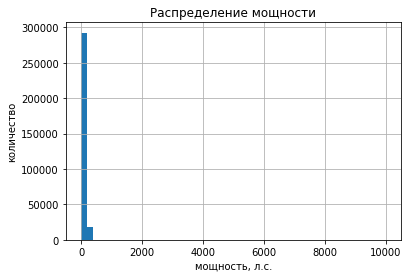

In [14]:
ax = pr_ds['Power'].hist(bins=50, range = (0, 10000))
ax.set_title('Распределение мощности')
ax.set_xlabel('мощность, л.с.')
ax.set_ylabel('количество')
plt.show()

Значения сосредоточились в диапазоне прмерно до 500 л.с. Посмотрим для него график распределения

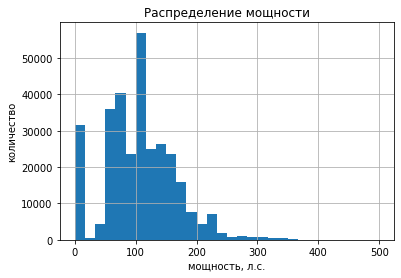

In [15]:
ax = pr_ds['Power'].hist(bins=30, range = (0, 500))
ax.set_title('Распределение мощности')
ax.set_xlabel('мощность, л.с.')
ax.set_ylabel('количество')
plt.show()

Есть мощный выброс в нулевом значении и почти отсутвуют значения после 350 л.с. Посмотрим еще распределение для диапазона 0-50

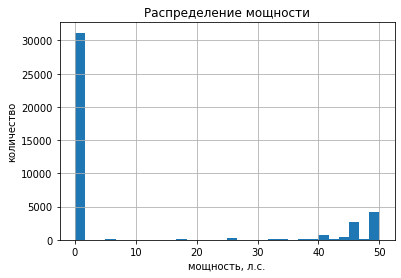

In [16]:
ax = pr_ds['Power'].hist(bins=30, range = (0, 50))
ax.set_title('Распределение мощности')
ax.set_xlabel('мощность, л.с.')
ax.set_ylabel('количество')
plt.show()

Отбросим аномальные значения и выбросы за пределами диапазона 40-350 л.с.

In [17]:
pr_ds = pr_ds.query('40 <= Power <= 350')
pr_ds.Power.describe()

count    277440.000000
mean        116.960298
std          49.138602
min          40.000000
25%          75.000000
50%         109.000000
75%         143.000000
max         350.000000
Name: Power, dtype: float64

Займемся обнаруженными пропусками. Больше всего пропусков в столбце NotRepaired, посмотрим на эти данные поближе

In [18]:
pr_ds['NotRepaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [19]:
pr_ds[ds['NotRepaired'].isnull()].head(10)

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,NotRepaired,RegistrationYear,Model,Price
2,suv,auto,163,125000,gasoline,jeep,NaN,2004,grand,9800
8,bus,manual,125,30000,petrol,ford,NaN,2014,c_max,14500
9,small,manual,101,150000,NaN,volkswagen,NaN,1998,golf,999
12,wagon,manual,115,150000,petrol,volkswagen,NaN,1995,passat,999
16,NaN,NaN,60,150000,petrol,volkswagen,NaN,2016,polo,300
31,NaN,manual,60,150000,petrol,renault,NaN,2016,clio,899
36,other,manual,75,70000,NaN,opel,NaN,1991,kadett,1600
41,sedan,auto,306,150000,NaN,mercedes_benz,NaN,2002,e_klasse,7500
42,sedan,auto,231,150000,gasoline,bmw,NaN,2006,5er,12500
44,small,auto,61,80000,petrol,smart,NaN,2008,fortwo,3900


Данные здесь относятся к категориальным. Автомобили разные, некоторым по несколько десятков лет, сомнительно, что они не ремонтировались ни разу. Видимо пользователи просто не указали этот параметр и восстановить его невозможно. Заполним пропуски в данном признаке новой категорией - 'undefined'.

In [20]:
pr_ds['NotRepaired'] = pr_ds['NotRepaired'].fillna('undefined')
pr_ds['NotRepaired'].isna().sum()

0

In [21]:
pr_ds.isna().sum()

VehicleType         10553
Gearbox              5076
Power                   0
Kilometer               0
FuelType            14896
Brand                   0
NotRepaired             0
RegistrationYear        0
Model               10320
Price                   0
dtype: int64

Восстановить признак Model по имеющимся данным затруднительно, но данный признак важен для определния стоимости авто. Посмотрим на частоту имеющихся значений данных в этом столбце.

In [22]:
pr_ds['Model'].value_counts()

golf                  23403
other                 18717
3er                   16304
polo                  10522
corsa                  9984
                      ...  
q3                        3
range_rover_evoque        2
gl                        2
serie_3                   2
rangerover                1
Name: Model, Length: 249, dtype: int64

На втором месте по встречаемости тип модели 'other'. Посмторим к каким брендам относятся неопределенные модели. 

In [23]:
pr_ds[pr_ds['Model'] == 'other']['Brand'].value_counts()

mercedes_benz    2253
fiat             1363
citroen          1359
ford             1112
hyundai           957
peugeot           893
suzuki            875
mazda             815
opel              792
audi              760
chevrolet         727
renault           707
toyota            677
mitsubishi        624
volkswagen        561
nissan            555
volvo             497
alfa_romeo        439
kia               402
saab              330
rover             313
chrysler          312
honda             251
skoda             186
porsche           112
jaguar            111
bmw                93
jeep               92
daihatsu           88
lancia             82
daewoo             76
mini               64
subaru             55
seat               54
smart              46
lada               39
dacia              20
land_rover         13
trabant            12
Name: Brand, dtype: int64

Бренды встречаются совершенно разные. Для пропусков в категории моделей заполним данные существующим значением 'other'.

In [24]:
pr_ds['Model'] = pr_ds['Model'].fillna('other')
pr_ds['Model'].isna().sum()

0

In [25]:
pr_ds.isna().sum()

VehicleType         10553
Gearbox              5076
Power                   0
Kilometer               0
FuelType            14896
Brand                   0
NotRepaired             0
RegistrationYear        0
Model                   0
Price                   0
dtype: int64

Оставшиеся пропуски попробуем заполнить характерными значениями на основе имеющихся данных в других столбцах.
Создадим для этого специальную функцию.

In [26]:
# Функция принимает имя столбца для заполнения пропусков и список столбцов
# по которым будет искаться для пропуска характерное значение 

def func_fill_(col_fill, columns):
    #новый столбец с объединенными данными для группировки
    pr_ds['new_col'] = pr_ds[columns].sum(axis=1)  
    #группируем и отбираем характерные значения    
    dt_fill = pr_ds.groupby('new_col').agg(lambda x: x.mode(dropna=False)[0])[col_fill]
    #заполняем пропуски
    pr_ds.loc[pr_ds[col_fill].isna(), col_fill] = pr_ds.loc[
        pr_ds[col_fill].isna(), 'new_col'].apply(lambda x: dt_fill[x])
    #удаляем ненужный столбец
    pr_ds.drop('new_col', axis=1, inplace=True)

Для заполнения столбца 'VehicleType' (тип автомобильного кузова) используем данные из столбцов 'Brand' и 'Model'

In [27]:
func_fill_('VehicleType', ['Brand', 'Model'])
pr_ds.VehicleType.isna().sum()

1

Оставшиеся строки с пропусками удаляем

In [28]:
pr_ds = pr_ds.dropna(subset=['VehicleType'])
pr_ds.VehicleType.isna().sum()

0

In [29]:
pr_ds.isna().sum()

VehicleType             0
Gearbox              5076
Power                   0
Kilometer               0
FuelType            14896
Brand                   0
NotRepaired             0
RegistrationYear        0
Model                   0
Price                   0
dtype: int64

Для заполнения столбца 'FuelType' используем данные из столбцов 'Brand', 'Model', 'VehicleType'

In [30]:
func_fill_('FuelType', ['Brand', 'Model', 'VehicleType'])
pr_ds.FuelType.isna().sum()

38

Оставшиеся строки с пропусками удаляем

In [31]:
pr_ds = pr_ds.dropna(subset=['FuelType'])
pr_ds.FuelType.isna().sum()

0

In [32]:
pr_ds.isna().sum()

VehicleType            0
Gearbox             5072
Power                  0
Kilometer              0
FuelType               0
Brand                  0
NotRepaired            0
RegistrationYear       0
Model                  0
Price                  0
dtype: int64

Для заполнения столбца 'Gearbox' используем данные из столбцов 'Brand' и 'Model'

In [33]:
pr_ds.Gearbox.isna().sum()

5072

In [34]:
func_fill_('Gearbox', ['Brand', 'Model'])
pr_ds.Gearbox.isna().sum()

0

Оставшиеся строки с пропусками удаляем

In [35]:
pr_ds = pr_ds.dropna(subset=['Gearbox'])
pr_ds.Gearbox.isna().sum()

0

In [36]:
pr_ds.isna().sum().sum()

0

In [37]:
pr_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277401 entries, 2 to 354368
Data columns (total 10 columns):
VehicleType         277401 non-null object
Gearbox             277401 non-null object
Power               277401 non-null int64
Kilometer           277401 non-null int64
FuelType            277401 non-null object
Brand               277401 non-null object
NotRepaired         277401 non-null object
RegistrationYear    277401 non-null int64
Model               277401 non-null object
Price               277401 non-null int64
dtypes: int64(4), object(6)
memory usage: 23.3+ MB


Посмтрим на признак Gearbox

In [38]:
pr_ds.Gearbox.value_counts()

manual    225661
auto       51740
Name: Gearbox, dtype: int64

Признак принимает только 2 значения 'manual' и 'auto', можно перевести их в бинарный тип для простоты дальнейшей обработки

In [39]:
pr_ds.loc[pr_ds['Gearbox'] == 'manual', 'Gearbox'] = 1
pr_ds.loc[pr_ds['Gearbox'] == 'auto', 'Gearbox'] = 0
pr_ds.Gearbox.value_counts()

1    225661
0     51740
Name: Gearbox, dtype: int64

In [40]:
pr_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277401 entries, 2 to 354368
Data columns (total 10 columns):
VehicleType         277401 non-null object
Gearbox             277401 non-null int64
Power               277401 non-null int64
Kilometer           277401 non-null int64
FuelType            277401 non-null object
Brand               277401 non-null object
NotRepaired         277401 non-null object
RegistrationYear    277401 non-null int64
Model               277401 non-null object
Price               277401 non-null int64
dtypes: int64(5), object(5)
memory usage: 23.3+ MB


Данные подготовлены. Исключены столбцы с избыточными данными, удалены аномальные и нетипичные значения. Некоторые данные удалось восстановить. Общий объем записей в выборке уменьшился на 22%.

## Обучение моделей

Так как не все библиотеки поддерживают работу с категориальными признаками, подготовим отдельную выборку, в кторой преобразуем категориальные признаки в численные. Можно исппользовать One-Hot Encoding, но у нас признак Brand имеет 40 уникальных значений, Model - 249. В итоге наша таблица значительно увеличится за счет появленния новых столбцов, что повлияет на время обработки. Попробуем применить метод OrdinalEncoder, дополнительно стандартизируем значения для компенсации потери их значимости из-за разности масштабов. 

In [41]:
cat_features = list(pr_ds.select_dtypes(include=['object']).columns)
cat_features

['VehicleType', 'FuelType', 'Brand', 'NotRepaired', 'Model']

In [42]:
pr_ds_enc = pr_ds.copy(deep=True)
pr_ds_enc[cat_features] = OrdinalEncoder().fit_transform(
    pr_ds_enc[cat_features]
)
display(pr_ds.head())
display(pr_ds_enc.head())

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,NotRepaired,RegistrationYear,Model,Price
2,suv,0,163,125000,gasoline,jeep,undefined,2004,grand,9800
3,small,1,75,150000,petrol,volkswagen,no,2001,golf,1500
4,small,1,69,90000,gasoline,skoda,no,2008,fabia,3600
5,sedan,1,102,150000,petrol,bmw,yes,1995,3er,650
6,convertible,1,109,150000,petrol,peugeot,no,2004,2_reihe,2200


,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,NotRepaired,RegistrationYear,Model,Price
2,6.0,0,163,125000,2.0,14.0,1.0,2004,117.0,9800
3,5.0,1,75,150000,6.0,38.0,0.0,2001,116.0,1500
4,5.0,1,69,90000,2.0,31.0,0.0,2008,101.0,3600
5,4.0,1,102,150000,6.0,2.0,2.0,1995,11.0,650
6,1.0,1,109,150000,6.0,25.0,0.0,2004,8.0,2200


В основной выборке преобразуем категориальные признаки в соответствующий тип - category

In [43]:
for c in pr_ds.columns:
    col_type = pr_ds[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        pr_ds[c] = pr_ds[c].astype('category')
        
pr_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277401 entries, 2 to 354368
Data columns (total 10 columns):
VehicleType         277401 non-null category
Gearbox             277401 non-null int64
Power               277401 non-null int64
Kilometer           277401 non-null int64
FuelType            277401 non-null category
Brand               277401 non-null category
NotRepaired         277401 non-null category
RegistrationYear    277401 non-null int64
Model               277401 non-null category
Price               277401 non-null int64
dtypes: category(5), int64(5)
memory usage: 14.3 MB


Разделим данные в выборках на обучающие и тестовые.

In [44]:
features_train, features_valid, target_train, target_valid = train_test_split(
    pr_ds.drop('Price', axis=1), pr_ds.Price, test_size=0.25, random_state=12345)

features_train_enc, features_valid_enc, target_train_enc, target_valid_enc = train_test_split(
    pr_ds_enc.drop('Price', axis=1), pr_ds_enc.Price, test_size=0.25, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print()
print(features_train_enc.shape)
print(features_valid_enc.shape)

(208050, 9)
(69351, 9)

(208050, 9)
(69351, 9)


Выполним стандартизацию.

In [45]:
scaler = StandardScaler()

columns = features_train_enc.columns

scaler.fit(features_train_enc[columns]) 
features_train_enc[columns] = scaler.transform(features_train_enc[columns])
features_valid_enc[columns] = scaler.transform(features_valid_enc[columns])

display(features_train_enc.head())
display(features_valid_enc.head())

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,NotRepaired,RegistrationYear,Model
205517,1.299900,-2.084375,1.078554,0.55813,-1.515005,0.761220,-0.535689,1.207481,0.761681
279667,1.299900,-2.084375,2.339803,0.55813,-1.515005,-1.495014,-0.535689,0.882940,0.804671
322520,-0.135617,0.479760,-0.854005,0.55813,0.669466,0.686012,-0.535689,-0.090681,0.145479
24385,-1.571134,0.479760,-0.019953,0.55813,0.669466,-0.141274,-0.535689,-1.875654,0.690029
278075,1.299900,0.479760,0.671700,0.55813,0.669466,-1.495014,-0.535689,-0.090681,-1.158575


,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,NotRepaired,RegistrationYear,Model
331879,-1.092628,-2.084375,1.383695,0.55813,0.669466,-0.066066,-0.535689,-3.660627,0.804671
127460,1.299900,0.479760,0.468272,0.55813,-2.607241,1.362883,-0.535689,-0.252951,1.736138
67087,-0.135617,0.479760,-0.243723,0.55813,-1.515005,0.686012,-0.535689,0.720670,0.432085
228772,-0.135617,0.479760,-0.854005,0.55813,0.669466,1.287675,2.510892,-0.415222,0.088158
73310,1.299900,-2.084375,0.163131,0.55813,-0.422770,-0.066066,-0.535689,-2.362465,-0.212777


Обучим и протестируем модели с разными гиперпараметрами. Будем использовать следующие алгоритмы:
- LGBMRegressor
- CatBoostRegressor с категориальными данными преобразованными в численные
- CatBoostRegressor с категориальными данными
- XGBRegressor
- RandomForestRegressor

Создадим сводную таблицу для сравнения результатов работы алгоритмов.

In [46]:
model_comparison = pd.DataFrame(columns=['Алгоритм', 'Время обучения, с', 'Время предсказания, с', 'RMSE на валидации, евро'])
display(model_comparison)

,Алгоритм,"Время обучения, с","Время предсказания, с","RMSE на валидации, евро"


Функция для настройки и тестирования алгоритмов

In [47]:
def  tuning_test_models(model_name, model, parameters, features, target, features_test, target_test):
    
    start = timer()
    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    grid.fit(features, target)
    stop = timer()
    time_tuning = stop - start
    
    best_model = grid.best_estimator_
    
    start = timer()
    best_model.fit(features, target) 
    stop = timer()
    time_fit = stop - start
    
    start = timer()
    target_predict = best_model.predict(features_test)
    stop = timer()
    time_predict = stop - start
    
    rmse = mean_squared_error(target_test, target_predict) ** 0.5
    

    print("\n========================================================")
    print(" Модель",  model_name)
    print("========================================================")
    
    print ('\n Время подбора параметров:\n',
          time_tuning)    
    print("\n Лучший результат по всем параметрам:\n",
          (grid.best_score_ * (-1))** 0.5)
    
    print("\n Лучшие параметры модели:\n",
          grid.best_params_)
    
    print("\n ========================================================")
    
    print ('\n Время обучения на лучшей модели:\n',
          time_fit)    
    print("\n Время предсказания на лучшей модели:\n",
          time_predict)
    
    print("\n RMSE на валидации:\n",
          rmse)
    print("\n ========================================================")
    
    result = {'Алгоритм' : model_name,
              'Время обучения, с' : round(time_fit, 3),
              'Время предсказания, с' : round(time_predict, 3),
              'RMSE на валидации, евро' : round(rmse, 2)}
    
    return result
    

Тестируем все алгоритмы, результаты заносим в сводную таблицу

In [48]:
%%time
model_results = tuning_test_models('LGBMRegressor', 
                                  LGBMRegressor(random_state=12345), 
                                  {'n_estimators' : [150, 200], 'learning_rate' : [0.1, 0.3]}, 
                                  features_train, 
                                  target_train,
                                  features_valid, 
                                  target_valid)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель LGBMRegressor

 Время подбора параметров:
 420.8673335984349

 Лучший результат по всем параметрам:
 1301.8942331376982

 Лучшие параметры модели:
 {'learning_rate': 0.3, 'n_estimators': 200}


 Время обучения на лучшей модели:
 9.905683979392052

 Время предсказания на лучшей модели:
 0.8045170530676842

 RMSE на валидации:
 1300.7645757282771



,Алгоритм,"Время обучения, с","Время предсказания, с","RMSE на валидации, евро"
0,LGBMRegressor,9.906,0.805,1300.76


CPU times: user 7min 4s, sys: 4.38 s, total: 7min 8s
Wall time: 7min 11s


In [49]:
%%time
model_results = tuning_test_models('CatBoostRegressor enc', 
                                  CatBoostRegressor(random_state=12345, verbose=10, iterations=150), 
                                  {'depth' : [5, 10], 'learning_rate' : [0.1, 0.5]}, 
                                  features_train_enc, 
                                  target_train_enc,
                                  features_valid_enc, 
                                  target_valid_enc)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)

0:	learn: 3393.6141723	total: 58.5ms	remaining: 8.71s
10:	learn: 2234.6995698	total: 918ms	remaining: 11.6s
20:	learn: 1889.4879410	total: 1.71s	remaining: 10.5s
30:	learn: 1750.5582117	total: 2.51s	remaining: 9.63s
40:	learn: 1672.6645843	total: 3.4s	remaining: 9.03s
50:	learn: 1625.7619338	total: 4.29s	remaining: 8.32s
60:	learn: 1590.4770582	total: 5.19s	remaining: 7.57s
70:	learn: 1564.0627472	total: 5.99s	remaining: 6.66s
80:	learn: 1539.9626251	total: 6.78s	remaining: 5.78s
90:	learn: 1523.4685975	total: 7.58s	remaining: 4.91s
100:	learn: 1509.5627643	total: 8.46s	remaining: 4.11s
110:	learn: 1496.1362824	total: 9.16s	remaining: 3.22s
120:	learn: 1486.0275865	total: 10s	remaining: 2.41s
130:	learn: 1477.6911009	total: 10.8s	remaining: 1.57s
140:	learn: 1469.8569701	total: 11.6s	remaining: 743ms
149:	learn: 1464.2863853	total: 12.3s	remaining: 0us
0:	learn: 3395.3999888	total: 10ms	remaining: 1.5s
10:	learn: 2238.4212501	total: 837ms	remaining: 10.6s
20:	learn: 1892.5491891	total:

,Алгоритм,"Время обучения, с","Время предсказания, с","RMSE на валидации, евро"
0,LGBMRegressor,9.906,0.805,1300.76
1,CatBoostRegressor enc,27.623,0.015,1308.10


CPU times: user 6min 15s, sys: 38.5 s, total: 6min 53s
Wall time: 7min 8s


In [50]:
%%time
model_results = tuning_test_models('CatBoostRegressor cat', 
                                  CatBoostRegressor(cat_features=cat_features, random_state=12345, verbose=10, iterations=150), 
                                  {'depth' : [5, 10], 'learning_rate' : [0.1, 0.5]}, 
                                  features_train, 
                                  target_train,
                                  features_valid, 
                                  target_valid)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)

0:	learn: 3394.7045689	total: 111ms	remaining: 16.6s
10:	learn: 2224.7180176	total: 1.7s	remaining: 21.5s
20:	learn: 1842.7287122	total: 3.19s	remaining: 19.6s
30:	learn: 1681.5220339	total: 4.68s	remaining: 18s
40:	learn: 1614.1615086	total: 6.08s	remaining: 16.2s
50:	learn: 1572.3261525	total: 7.58s	remaining: 14.7s
60:	learn: 1547.4437571	total: 9.07s	remaining: 13.2s
70:	learn: 1527.5195030	total: 10.6s	remaining: 11.8s
80:	learn: 1512.2428160	total: 12.1s	remaining: 10.3s
90:	learn: 1500.7161890	total: 13.5s	remaining: 8.78s
100:	learn: 1488.4559104	total: 14.9s	remaining: 7.25s
110:	learn: 1477.7641538	total: 16.3s	remaining: 5.74s
120:	learn: 1469.3820240	total: 17.8s	remaining: 4.28s
130:	learn: 1461.3371154	total: 19.4s	remaining: 2.82s
140:	learn: 1453.4702325	total: 20.8s	remaining: 1.33s
149:	learn: 1447.4539376	total: 22.2s	remaining: 0us
0:	learn: 3393.7862340	total: 109ms	remaining: 16.3s
10:	learn: 2223.1355084	total: 1.7s	remaining: 21.5s
20:	learn: 1837.6609184	total:

,Алгоритм,"Время обучения, с","Время предсказания, с","RMSE на валидации, евро"
0,LGBMRegressor,9.906,0.805,1300.76
1,CatBoostRegressor enc,27.623,0.015,1308.10
2,CatBoostRegressor cat,47.238,0.117,1311.33


CPU times: user 10min 39s, sys: 1min 21s, total: 12min 1s
Wall time: 12min 18s


In [51]:
%%time
model_results = tuning_test_models('XGBRegressor', 
                                  XGBRegressor(random_state=12345, objective = 'reg:squarederror'), 
                                  {'n_estimators' : [150, 200], 'learning_rate' : [0.1, 0.5]}, 
                                  features_train_enc, 
                                  target_train_enc,
                                  features_valid_enc, 
                                  target_valid_enc)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель XGBRegressor

 Время подбора параметров:
 265.4662182070315

 Лучший результат по всем параметрам:
 1397.3896466581812

 Лучшие параметры модели:
 {'learning_rate': 0.5, 'n_estimators': 200}


 Время обучения на лучшей модели:
 17.742915581911802

 Время предсказания на лучшей модели:
 0.40184352546930313

 RMSE на валидации:
 1397.1584909295216



,Алгоритм,"Время обучения, с","Время предсказания, с","RMSE на валидации, евро"
0,LGBMRegressor,9.906,0.805,1300.76
1,CatBoostRegressor enc,27.623,0.015,1308.10
2,CatBoostRegressor cat,47.238,0.117,1311.33
3,XGBRegressor,17.743,0.402,1397.16


CPU times: user 4min 39s, sys: 3.36 s, total: 4min 43s
Wall time: 4min 43s


In [52]:
%%time
model_results = tuning_test_models('RandomForestRegressor', 
                                  RandomForestRegressor(random_state=12345, n_estimators=100), 
                                  {'max_depth' : [9, 18]}, 
                                  features_train_enc, 
                                  target_train_enc,
                                  features_valid_enc, 
                                  target_valid_enc)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель RandomForestRegressor

 Время подбора параметров:
 323.9229615777731

 Лучший результат по всем параметрам:
 1325.2251781387242

 Лучшие параметры модели:
 {'max_depth': 18}


 Время обучения на лучшей модели:
 43.3012319765985

 Время предсказания на лучшей модели:
 1.8777485899627209

 RMSE на валидации:
 1317.156321310183



,Алгоритм,"Время обучения, с","Время предсказания, с","RMSE на валидации, евро"
0,LGBMRegressor,9.906,0.805,1300.76
1,CatBoostRegressor enc,27.623,0.015,1308.10
2,CatBoostRegressor cat,47.238,0.117,1311.33
3,XGBRegressor,17.743,0.402,1397.16
4,RandomForestRegressor,43.301,1.878,1317.16


CPU times: user 6min 4s, sys: 4.55 s, total: 6min 8s
Wall time: 6min 9s


Модели обучены и протестированы на валидацонной выборке. Результаты работы моделей собраны в итоговую таблицу. Проведем анализ полученных данных.

## Анализ моделей

Рассмотрим на диаграмме результаты измерения качества моделей на валидационной выборке.

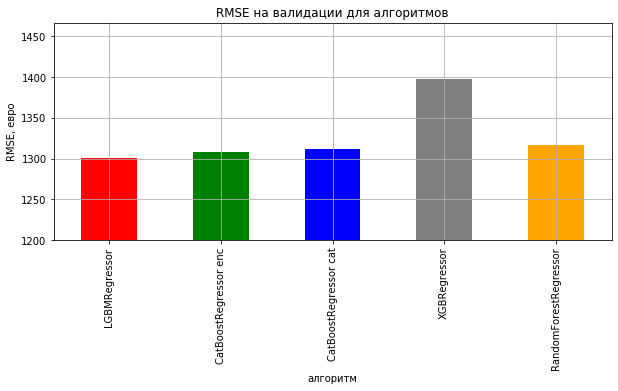

In [53]:
ax = (
        model_comparison.plot(
            x='Алгоритм',
            y='RMSE на валидации, евро',
            kind='bar',
            grid=True,
            color=["red", "green", "blue", "gray", "orange"],
            figsize=(10, 4))
)
ax.set_title('RMSE на валидации для алгоритмов')
ax.set_xlabel('алгоритм')
ax.set_ylabel('RMSE, евро')
ax.legend().remove()
plt.ylim(bottom=1200)
plt.show()

Лучший результат RMSE демонстрирует алгоритм LGBMRegressor. CatBoostRegressor на обоих выборках показывает похожий результат, алгоритму  LGBMRegressor уступает совсем немного. RandomForestRegressor справился немного хуже, но не на много, а вот XGBRegressor показал заметно большую ошибку в сравнении с остальными. 

Посмтрим на время обучения алгоритмов.

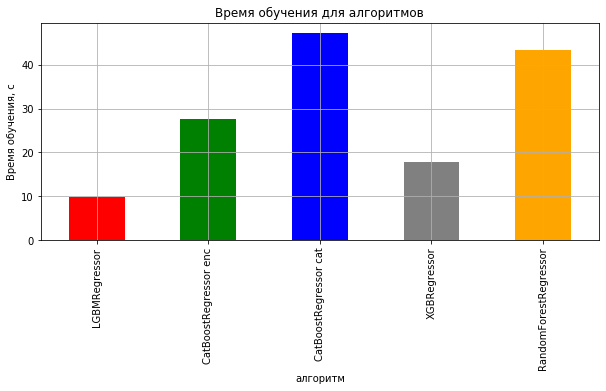

In [54]:
ax = (
        model_comparison.plot(
            x='Алгоритм',
            y='Время обучения, с',
            kind='bar',
            grid=True,
            color=["red", "green", "blue", "gray", "orange"],
            figsize=(10, 4))
)
ax.set_title('Время обучения для алгоритмов')
ax.set_xlabel('алгоритм')
ax.set_ylabel('Время обучения, с')
ax.legend().remove()
plt.show()

Снова лидирует LGBMRegressor. Относительно быстро справляется XGBRegressor. Скорость обучения для CatBoostRegressor на данных содержащих категориальные признаки ниже почти в 2 раза в сравнении с численными. Также медленно, отноистельно других, обучается модель RandomForestRegressor. 

Посмтрим на распределения времени предсказания.

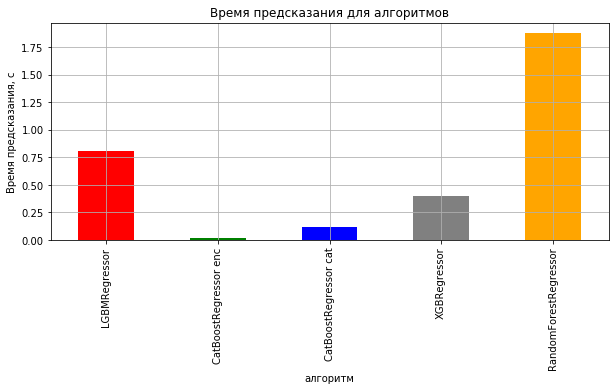

In [55]:
ax = (
        model_comparison.plot(
            x='Алгоритм',
            y='Время предсказания, с',
            kind='bar',
            grid=True,
            color=["red", "green", "blue", "gray", "orange"],
            figsize=(10, 4))
)
ax.set_title('Время предсказания для алгоритмов')
ax.set_xlabel('алгоритм')
ax.set_ylabel('Время предсказания, с')
ax.legend().remove()
plt.show()

Все модели справляются менее чем за 2 секунды. В лидерах алгоритмы CatBoostRegressor. Лидер в точности и скорости обучения LGBMRegressor - здесь демонстриует не самый лучший результат. Дольше всех предсказывает RandomForestRegressor.

## Выводы

В результате выполнения данного проекта были построены модели для определения стоимости автомобилей с пробегом. Для этого были проведены анализ и подготовка исторических данных: технических характеристик, комплектаций и цен автомобилей. Различными меодами, с подбором гиперпараметров, были обучены разные модели и протестирована их работа. Анализ полученных моделей показал, что если важны качество предсказания и время обучения, то наилучшие результаты показывает модель LGBMRegressor. CatBoostRegressor демонстрирует самую высокую скорость предсказания. На скорость работы алгоритма CatBoostRegressor влияет качество подготовки данных.  